In [79]:
from binance.client import Client
import pandas as pd
import yfinance as yf
import requests
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:
#Données de refinitiv workspace si besoin
# import cufflinks as cf 
# import refinitiv.data as rd
# rd.open_session()
# cf.set_config_file(offline=True)  # set the plotting mode to offline

In [2]:
# api_key = ' API '
# api_secret = 'API secrete'

# client = Client(api_key, api_secret)

In [3]:
# def get_close_data(symbol, interval, start_str, end_str=None):
#     """
#     Récupère uniquement les données de clôture pour un symbole donné via l'API Binance.
#     """
#     klines = client.get_historical_klines(symbol, interval, start_str, end_str)
#     # Extraire uniquement les colonnes utiles : "Open time" et "Close"
#     data = pd.DataFrame(klines, columns=['Open time', 'Close'] + ['_']*10)
#     data['Open time'] = pd.to_datetime(data['Open time'], unit='ms')
#     data.set_index('Open time', inplace=True)
#     data['Close'] = data['Close'].astype(float)
#     return data[['Close']]

# # Définir la période et l'intervalle
# start_date = "2024-03-31"
# end_date = "2025-02-15"
# interval = Client.KLINE_INTERVAL_1MINUTE

# # Récupérer uniquement les données de clôture pour ETH et SFP
# df_eth = get_close_data("ETHUSDT", interval, start_date, end_date)
# df_sfp = get_close_data("SFPUSDT", interval, start_date, end_date)

# # Renommer les colonnes pour différencier
# df_eth.rename(columns={'Close': 'Close_ETH'}, inplace=True)
# df_sfp.rename(columns={'Close': 'Close_SFP'}, inplace=True)

# # Fusionner les deux DataFrames sur l'index temporel
# df = pd.merge_asof(df_eth.sort_index(), df_sfp.sort_index(), left_index=True, right_index=True)

# # Calculer le spread et le z-score avec une fenêtre glissante (ici 60 minutes)
# df['spread'] = df['Close_ETH'] - df['Close_SFP']
# window = 60
# df['spread_mean'] = df['spread'].rolling(window).mean()
# df['spread_std'] = df['spread'].rolling(window).std()
# df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# df.dropna(inplace=True)
# print(df.head())

                     Close_ETH  Close_SFP     spread  spread_mean  spread_std  \
Open time                                                                       
2024-03-31 00:59:00    3518.61     0.7551  3517.8549  3513.519777    4.146388   
2024-03-31 01:00:00    3518.20     0.7547  3517.4453  3513.728965    4.018474   
2024-03-31 01:01:00    3518.20     0.7545  3517.4455  3513.908805    3.937160   
2024-03-31 01:02:00    3516.36     0.7547  3515.6053  3514.077292    3.784387   
2024-03-31 01:03:00    3515.01     0.7555  3514.2545  3514.242418    3.562251   

                     spread_zscore  
Open time                           
2024-03-31 00:59:00       1.045518  
2024-03-31 01:00:00       0.924813  
2024-03-31 01:01:00       0.898286  
2024-03-31 01:02:00       0.403766  
2024-03-31 01:03:00       0.003392  


In [71]:
#df.to_csv("dataset_crypto_projet.csv")

In [77]:
df = pd.read_csv("dataset_crypto_projet.csv", parse_dates=['Open time'])
df.set_index('Open time', inplace=True)
# Calculer le spread et le z-score avec une fenêtre glissante (ici 60 minutes)
df['spread'] = df['Close_ETH'] - df['Close_SFP']
window = 60
df['spread_mean'] = df['spread'].rolling(window).mean()
df['spread_std'] = df['spread'].rolling(window).std()
df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

df.dropna(inplace=True)
print(df.head())

                     Close_ETH  Close_SFP       spread  spread_mean  \
Open time                                                             
2024-03-31 02:57:00  3568.9966   0.755073  3568.241527  3566.719516   
2024-03-31 02:58:00  3568.0068   0.755172  3567.251628  3566.897522   
2024-03-31 02:59:00  3568.3199   0.755865  3567.564035  3567.048761   
2024-03-31 03:00:00  3567.5321   0.756162  3566.775938  3567.198480   
2024-03-31 03:01:00  3566.9968   0.756162  3566.240638  3567.364350   

                     spread_std  spread_zscore  
Open time                                       
2024-03-31 02:57:00    5.986835       0.254226  
2024-03-31 02:58:00    5.836885       0.060667  
2024-03-31 02:59:00    5.731957       0.089895  
2024-03-31 03:00:00    5.601938      -0.075428  
2024-03-31 03:01:00    5.417735      -0.207414  


In [78]:
df_sim = df

In [88]:
def simulate_strategy_with_entry_offset_stoploss(df_period, threshold, entry_offset=0.4, fee=0.0005, stoploss=-0.03):
    """
    Simule la stratégie sur une période donnée (df_period) en utilisant :
      - Entrée : si spread_zscore > (threshold + entry_offset), alors on ouvre une position short (-1)
                 si spread_zscore < -(threshold + entry_offset), alors on ouvre une position long (+1)
      - Une fois en position, le trade reste ouvert jusqu'à ce que :
          * Pour une position short, le z-score descende en dessous de threshold, ou
          * Pour une position long, le z-score remonte au-dessus de -threshold, 
          * Ou que le rendement cumulatif du trade atteigne le stoploss de -3%
      - Les frais de transaction de 0,05 % sont appliqués à chaque changement de position.
      - Un décalage d'une minute (shift(-1)) est appliqué pour simuler l'exécution.
    
    Retourne (total_return, sharpe_ratio) sur la période.
    """
    df_sim = df_period.copy().reset_index()  # "index" contient le timestamp
    positions = []
    pos = 0          # Position initiale neutre
    trade_entry = None  # Pour mémoriser le spread au moment de l'entrée
    # Simulation minute par minute
    for idx, row in df_sim.iterrows():
        z = row['spread_zscore']
        current_spread = row['spread']
        
        if pos == 0:
            # Conditions d'entrée
            if z > (threshold + entry_offset):
                pos = -1    # Ouverture de position short
                trade_entry = current_spread
            elif z < -(threshold + entry_offset):
                pos = 1     # Ouverture de position long
                trade_entry = current_spread
        else:
            # Si une position est ouverte, calculer le rendement cumulatif depuis l'entrée
            if trade_entry is not None:
                if pos == -1:
                    # Pour une position short, profit si le spread diminue
                    cum_return = (current_spread / trade_entry - 1) * (-1)
                else:  # pos == 1
                    # Pour une position long, profit si le spread augmente
                    cum_return = (current_spread / trade_entry - 1) * (1)
            else:
                cum_return = 0

            # Stop-loss : si le rendement cumulatif descend en dessous de -3%
            if cum_return < stoploss:
                pos = 0
                trade_entry = None
            else:
                # Conditions de sortie normales
                if pos == -1 and z < threshold:
                    pos = 0
                    trade_entry = None
                elif pos == 1 and z > -threshold:
                    pos = 0
                    trade_entry = None
        positions.append(pos)
    
    df_sim['position'] = positions
    # On applique la position de la minute suivante pour simuler l'exécution
    df_sim['position_shifted'] = df_sim['position'].shift(1)
    # Calcul du rendement du spread (variation en % d'une minute)
    df_sim['spread_return'] = df_sim['spread'].pct_change().shift(-1)
    # Détecter les changements de position pour appliquer les frais
    df_sim['position_change'] = df_sim['position'].diff().abs().fillna(0)
    # Calcul du rendement de la stratégie en tenant compte des frais
    df_sim['strategy_return'] = df_sim['position_shifted'] * df_sim['spread_return'] - fee * df_sim['position_change']
    
    total_return = df_sim['strategy_return'].sum()
    strategy_returns = df_sim['strategy_return'].dropna()
    sharpe = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else -np.inf
    return total_return, sharpe


# On utilise une fenêtre glissante de 3 jours, décalée d'un jour.
dates = df.index.normalize().unique()
results = []
i = 0

while i < len(dates) - 3:
    window_start = dates[i]
    window_end = window_start + pd.Timedelta(days=3)
    window_df = df.loc[window_start:window_end]
    
    # Vérifier que la fenêtre contient suffisamment de données (au moins 3 jours complets)
    if window_df.empty or (window_df.index[-1] - window_df.index[0]).days < 2:
        i += 1
        continue
    
    best_threshold = None
    best_sharpe = -np.inf
    best_return = None
    
    # Tester des seuils entre 4.5 et 6.5 par pas de 0.1
    for th in np.arange(4.5, 6.5, 0.1):
        tot_return, sharpe = simulate_strategy_with_entry_offset_stoploss(window_df, threshold=th, entry_offset=0.4, fee=0.0005, stoploss=-0.03)
        if tot_return > 0 and sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = th
            best_return = tot_return
    
    # Si aucun seuil rentable n'est trouvé pour cette fenêtre, on décale d'un jour et on réessaie
    if best_threshold is None:
        i += 1
        continue
    else:
        # Une fois le seuil optimal trouvé pour cette fenêtre, on simule la stratégie sur la période cible suivante (les 3 jours suivants)
        target_start = window_end
        target_end = target_start + pd.Timedelta(days=3)
        target_df = df.loc[target_start:target_end]
        if target_df.empty:
            target_return = np.nan
        else:
            target_return, _ = simulate_strategy_with_entry_offset_stoploss(target_df, threshold=best_threshold, entry_offset=0.4, fee=0.0005, stoploss=-0.03)
        
        results.append({
            'window_start': window_start,
            'window_end': window_end,
            'optimal_threshold': best_threshold,
            'window_sharpe': best_sharpe,
            'window_return': best_return,
            'target_start': target_start,
            'target_end': target_end,
            'target_return': target_return
        })
        # Décalage de la fenêtre d'un jour
        i += 1

print(results)
df_results = pd.DataFrame(results)
df_results['window_start'] = pd.to_datetime(df_results['window_start'])
df_results.set_index('window_start', inplace=True)

print("Résultats des fenêtres glissantes de 3 jours :")
print(df_results.head())

[{'window_start': Timestamp('2024-04-05 00:00:00'), 'window_end': Timestamp('2024-04-08 00:00:00'), 'optimal_threshold': 3.6000000000000005, 'window_sharpe': 0.01260344072020503, 'window_return': 0.0035458085503694593, 'target_start': Timestamp('2024-04-08 00:00:00'), 'target_end': Timestamp('2024-04-11 00:00:00'), 'target_return': -0.005634749110350218}, {'window_start': Timestamp('2024-04-06 00:00:00'), 'window_end': Timestamp('2024-04-09 00:00:00'), 'optimal_threshold': 4.000000000000001, 'window_sharpe': 0.011646774654130868, 'window_return': 0.0021424432701533398, 'target_start': Timestamp('2024-04-09 00:00:00'), 'target_end': Timestamp('2024-04-12 00:00:00'), 'target_return': -0.0098180209706572}, {'window_start': Timestamp('2024-04-10 00:00:00'), 'window_end': Timestamp('2024-04-13 00:00:00'), 'optimal_threshold': 4.900000000000002, 'window_sharpe': 0.002457955631375405, 'window_return': 0.0014467106441590216, 'target_start': Timestamp('2024-04-13 00:00:00'), 'target_end': Times

In [90]:
df_results.to_csv("df_results.csv")

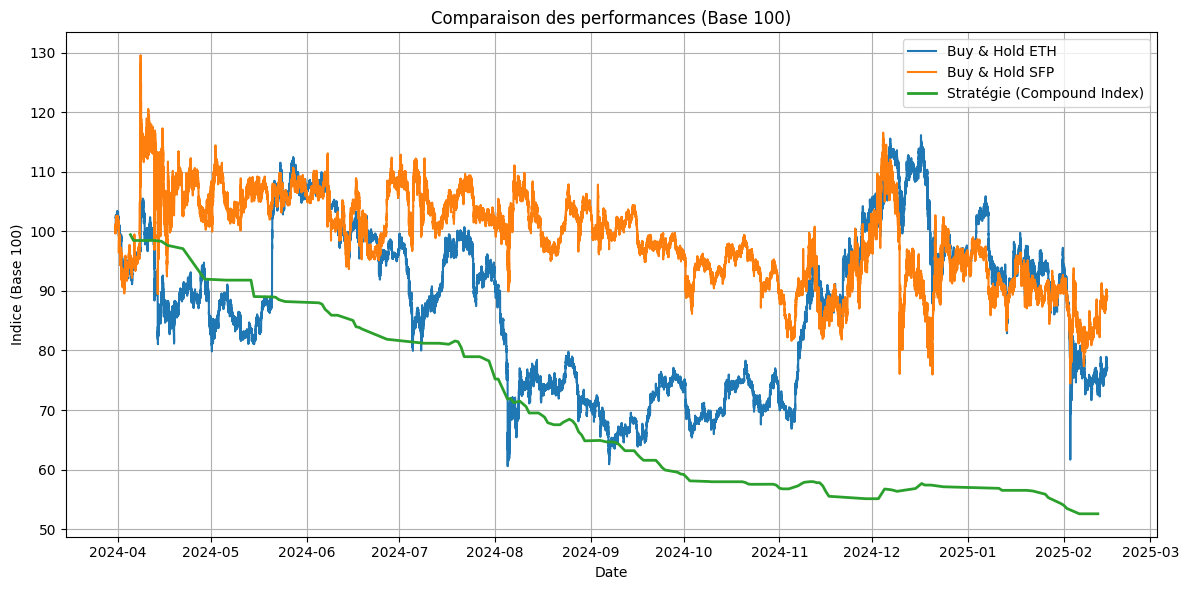

In [91]:
pd.read_csv('df_results.csv')
# 1. Calculer l'indice de la stratégie (en base 100)
df_results_clean = df_results.dropna(subset=['target_return']).copy()
df_results_clean['strategy_index'] = 100 * (1 + df_results_clean['target_return']).cumprod()

# 2. Calculer l'indice Buy & Hold pour ETH et SFP
# Utiliser la première date de votre DataFrame comme base
base_date = df.index.min()
base_ETH = df.loc[base_date, 'Close_ETH']
base_SFP = df.loc[base_date, 'Close_SFP']

df['Index_ETH'] = df['Close_ETH'] / base_ETH * 100
df['Index_SFP'] = df['Close_SFP'] / base_SFP * 100

# 3. Tracer les trois courbes sur un même graphique
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Index_ETH'], label="Buy & Hold ETH", linewidth=1.5)
plt.plot(df.index, df['Index_SFP'], label="Buy & Hold SFP", linewidth=1.5)
plt.plot(df_results_clean.index, df_results_clean['strategy_index'], label="Stratégie (Compound Index)", linewidth=2)
plt.title("Comparaison des performances (Base 100)")
plt.xlabel("Date")
plt.ylabel("Indice (Base 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

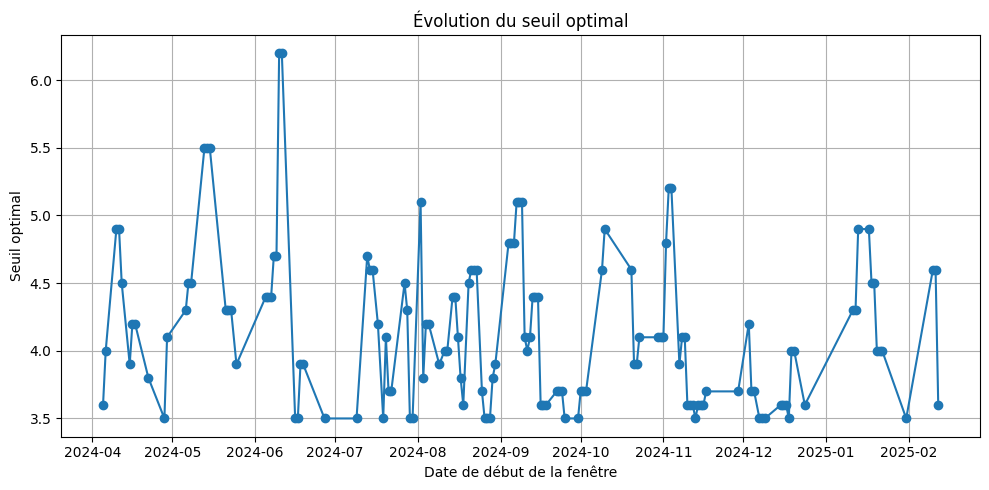

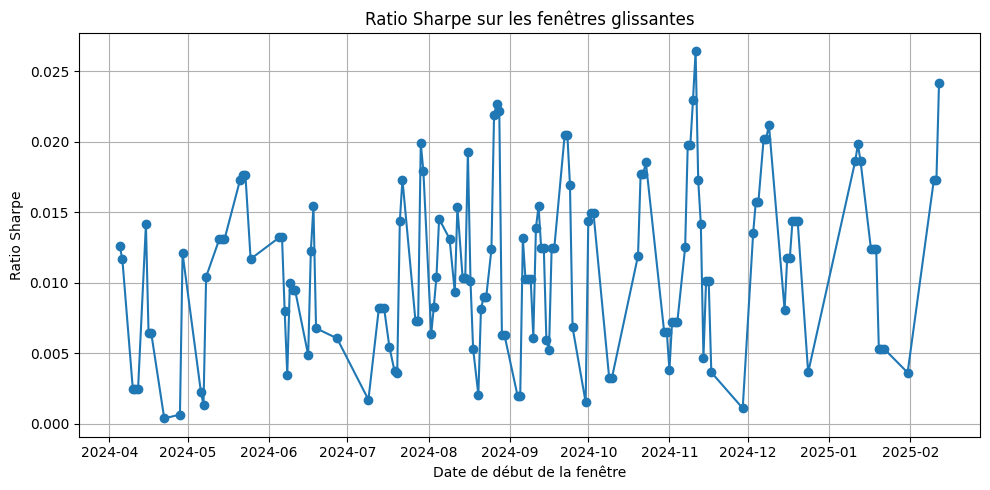

In [87]:


# Graphique 2 : Évolution du seuil optimal au fil du temps
plt.figure(figsize=(10,5))
plt.plot(df_results.index, df_results['optimal_threshold'], marker='o', linestyle='-')
plt.title("Évolution du seuil optimal")
plt.xlabel("Date de début de la fenêtre")
plt.ylabel("Seuil optimal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique 3 : Ratio Sharpe par fenêtre
plt.figure(figsize=(10,5))
plt.plot(df_results.index, df_results['window_sharpe'], marker='o', linestyle='-')
plt.title("Ratio Sharpe sur les fenêtres glissantes")
plt.xlabel("Date de début de la fenêtre")
plt.ylabel("Ratio Sharpe")
plt.grid(True)
plt.tight_layout()
plt.show()

***Pour l'implementation en direct sur Binance Testnet***

In [ ]:
api_key = 'API Binancetestnet'
api_secret = 'api secret'
client = Client(api_key, api_secret, testnet=True)

In [ ]:
# #Pour l'implementer sur binance testnet
# #Il faut juste remplacer l'api par l'api binance testnet


# print("\nDébut de l'exécution en temps réel sur Binance Testnet...")
# try:
#     while True:
#         # Récupérer les dernières 120 minutes de données (pour avoir suffisamment de points pour le rolling)
#         end_time = pd.to_datetime("now")
#         start_time = end_time - pd.Timedelta(minutes=120)
#         eth_data = get_close_data("ETHUSDT", interval, start_time.strftime("%Y-%m-%d %H:%M:%S"), end_time.strftime("%Y-%m-%d %H:%M:%S"))
#         sfp_data = get_close_data("SFPUSDT", interval, start_time.strftime("%Y-%m-%d %H:%M:%S"), end_time.strftime("%Y-%m-%d %H:%M:%S"))
#         eth_data.rename(columns={'Close': 'Close_ETH'}, inplace=True)
#         sfp_data.rename(columns={'Close': 'Close_SFP'}, inplace=True)
#         df_rt = pd.merge_asof(eth_data.sort_index(), sfp_data.sort_index(), left_index=True, right_index=True)
#         df_rt['spread'] = df_rt['Close_ETH'] - df_rt['Close_SFP']
#         df_rt['spread_mean'] = df_rt['spread'].rolling(window=60).mean()
#         df_rt['spread_std'] = df_rt['spread'].rolling(window=60).std()
#         df_rt['spread_zscore'] = (df_rt['spread'] - df_rt['spread_mean']) / df_rt['spread_std']
#         df_rt.dropna(inplace=True)
        
#         if not df_rt.empty:
#             latest_z = df_rt['spread_zscore'].iloc[-1]
#             print("Dernier z-score:", latest_z)
#             # Exemple de logique : si le z-score dépasse (fixed_threshold + 0.3), ouvrir une position short
#             if latest_z > (fixed_threshold + 0.3):
#                 print("Signal: Ouvrir une position short sur ETHUSDT et long sur SFPUSDT")
#                 try:
#                     order_eth = client.create_order(
#                         symbol="ETHUSDT",
#                         side=Client.SIDE_SELL,
#                         type=Client.ORDER_TYPE_MARKET,
#                         quantity=0.01  # Ajuster selon votre gestion du risque
#                     )
#                     order_sfp = client.create_order(
#                         symbol="SFPUSDT",
#                         side=Client.SIDE_BUY,
#                         type=Client.ORDER_TYPE_MARKET,
#                         quantity=10  # Ajuster selon votre stratégie
#                     )
#                     print("Ordres passés:", order_eth, order_sfp)
#                 except Exception as e:
#                     print("Erreur lors de la création d'ordres:", e)
#             elif latest_z < -(fixed_threshold + 0.3):
#                 print("Signal: Ouvrir une position long sur ETHUSDT et short sur SFPUSDT")
#                 try:
#                     order_eth = client.create_order(
#                         symbol="ETHUSDT",
#                         side=Client.SIDE_BUY,
#                         type=Client.ORDER_TYPE_MARKET,
#                         quantity=0.01
#                     )
#                     order_sfp = client.create_order(
#                         symbol="SFPUSDT",
#                         side=Client.SIDE_SELL,
#                         type=Client.ORDER_TYPE_MARKET,
#                         quantity=10
#                     )
#                     print("Ordres passés:", order_eth, order_sfp)
#                 except Exception as e:
#                     print("Erreur lors de la création d'ordres:", e)
#             else:
#                 print("Aucun signal détecté.")
#         else:
#             print("Pas de données suffisantes pour recalculer les indicateurs.")
        
#         # Pause de 60 secondes avant de refaire une vérification
#         time.sleep(60)
        
# except KeyboardInterrupt:
#     print("Arrêt de l'exécution en temps réel.")

